## DEMO PARSEADOR HOJAS DE VIDA

En este demo se busca realizar una demostracíon de como se puede extraer la información de una hoja de vida contando con unos parametros de entrada en formato json. la hoja de vida de referencia esta en el siguiente link [Hoja de Vida Referencia](https://drive.google.com/file/d/1l0P5Wgsay-e8s7HQ_eNi6as94hDf4k5a/view?usp=sharing). Este codigo se encarga de recibir estos parametros de entrada en formato json como lo pueden ser: 
1. sueldo 
2. conocimientos en lenguajes o tecnologias especificas.
3. Idiomas que domine el candidato.
4. Si cuenta o no con tarjeta profesional registrada en su hoja de vida.
5. Estudios especificos en algun campo que se requiera.

La funcion parsing_hv se encarga de procesar estos requisitos y devolver un json nuevo con los campos que cumpla la personas, adicionalmente de entregar otros datos de la hoja de vida que para este demo son:

1. Nombre del Candidato.
2. Experiencia con la que cuenta en la hoja de vida.
3. edad del candidato.
4. Si cuenta o no con tarjeta profesional registrada en su hoja de vida.
5. Sueldo o aspiracion Salarial registrada en la hoja de vida del candidato.
6. Conocimientos esecificos con los que cuente la persona en: Bases de Datos, Lengiajes de Programación, frameworks, herramientas de Nube. Estos campos se retornaran vacios en caso que el candidato no cuente con alguna de estas habilidades o conocimientos.
7. Idiomas que maneje y registre en su hoja de vida segun requerimiento de entrada. 
8. Estudios que maneje y registre en su hoja de vida segun requerimiento de entrada. 
9. Una ponderación en porcentaje de coincidencia de los valores solcitidados contra los valores o requisitos encontrados en la hoja de vida, esto expresado en un procentaje sobre un 100%.

A continuacion se Explica un paso a paso de como funciona este codigo.

# PASOS PARA FUNCIONAMIENTO DEL CODIGO

1. Descargar los archivos "Hoja_de_vida.txt", "Hoja_de _vida.pdf" y json_prueba.json que se encuentran en el siguiente [Link](https://github.com/oscarlopezbello/Parsing_hv)
2. una vez descargados en su pc se deben adjuntar a google colab en la seccion de archivos que esta en la barra - parte superior izquierda.

 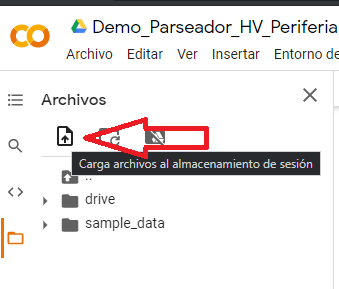



 3. intalar en su entorno de trabajo la libreria y paquetes de nltk para procesamiento de texto y lenguaje natural (NLP).

INSTALAR LIBRERIA NLTK

Para esto se deben ejecutar los siguientes tres bloques de codigo.

In [7]:
pip install nltk ## Bloque 1

In [8]:
nltk.download('averaged_perceptron_tagger') # Bloque 2

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
nltk.download('punkt') # Bloque 3

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Posterior a este ejecucion ya se puede correr el siguiente codigo el cual se encuentra con comentarios de la explicacion de cada parte y su funcion.

In [29]:
import json
import nltk
import re
import os
from datetime import datetime
import base64
from pathlib import Path
from google.colab import drive

A continuacion se crea la función parsing_hv la cual tiene como parametro de entrada el archivo Json_Prueba.json, este es un archivo con requisitos de busqueda que debe tener la hoja de vida.

In [120]:
def parsing_hv (json_frontend):
    ## La funcion nombre_candidato permite extraer el nombre del candidato de la hoja de vida
    ## usando la libreria nltk que utiliza NLP para procesar texto e identificar nombres propios
    def nombre_candidato (cadena):
        tags = nltk.pos_tag(nltk.word_tokenize(cadena))
        nouns = [(word, tag) for word, tag in tags if tag in ['NN','NNS', 'NNP', 'NNPS']]
        nombres = nouns[0:3]
        nombre = ""
        for x in nombres:
            a="".join(x)
            nombre = nombre+a+""
            nombre = nombre.replace("NNP", " ").replace("\uf095","").replace("Ingeniería", "").replace("NNS"," ").replace("\uf00c","").replace("NN"," ")
        return nombre
    ## La funcion read_file permite leer ficheros de ubicacion de las hojas de vida
    def read_file(path):
        items = []
        f = open(path)
        for x in f:
            items.append(str(x.replace('\n','')))
        f.close()
        return items
    ## La funcion habilidades se encarga de tomar los parametros del json de entradas y buscar coincidencias en 
    ## la hoja de vida del candidato
    def habilidades (habilidad, string_json, texto):
        lista = []
        for a in habilidad:
            a = a.lower()
            a = a.strip()
            if a in texto:
                lista.append(a)
        json_hv[string_json] = lista
    ## La funcion coincidencias se encarga de ponderar la cantidad de requisitos que solicito a revisar en la hoja de 
    ## vida y compara con las coincidencias que encontro y pondera de 1 a 100 pociento su coincidencia con la busqueda        
    def coincidencias(busqueda, json_hv):
        set_parametros = set()
        total_encontrado = 0
        set_valores = set()
        dicc_parametros = {}
        for key in busqueda.keys():
            set_valores.add(key)
        
        for key, value in busqueda.items():
            lista=[]
            if type(value) == list:
                for i in value:
                    if i == "No aplica":
                        set_valores.remove(key)
                    lista.append(i.lower())
                        
                if len(value) == 0:
                    set_valores.remove(key)
                elif key in set_valores:
                    dicc_parametros[key] = len(value)
                busqueda[key]=lista   
                
        ponderacion = 100 / len(set_valores)+2

        for key, value in json_hv.items():
            contador = 0
            if key in set_valores:
            
                for i in value:
                    if str(i).lower() in busqueda[key]:
                        contador += 1
                dicc_parametros[key] = (dicc_parametros[key], contador)

        coincidencia = 0
        for key, value in dicc_parametros.items():
            coincidencia += (value[1] / value[0]) * ponderacion    
        return coincidencia
    ## La funcion hv_base64 se encarga de tomar la hoja de vida en pdf y codificarla a base 64
    def hv_base64 (ruta):
        data = open(ruta, "rb").read()
        encoded = base64.b64encode(data)
        hv_base64 = encoded.decode('utf-8')
        return hv_base64
    ## Se leen los parametros del json de entrada    
    parametros = json_frontend
    
    bases_datos = parametros["bases_de_datos"]
    lenguajes_programacion = parametros["lenguajes_de_programacion"] 
    frameworks = parametros["frameworks"]
    servicios_nube = parametros["nube"]
    cargos = parametros["cargos"]
    idiomas = parametros["idiomas"]
    estudios = parametros["estudios"]
    tarjeta = parametros["tarjeta_profesional"]
    sueldo = parametros["sueldo"]
    ## Se realiza la lectura de los archivos que tenemos en el fichero 
    files = []
    for file in os.listdir("/content"):
        if file.endswith(".txt"):
            files.append("/content" + "/" + file)

    lista_json = []
    for file in files:
        documento = open(file,encoding='utf-8')
        documento_txt = str(documento.read())
        json_hv = {}
        texto_limpio = ""
        ## Se busca que en el fichero se tenga un archivo .pdf para realizar la conversion a base 64 del archivo.
        filename = Path(file).stem
        ruta_pdf= "/content"
        link_hv = f"{ruta_pdf}/{filename}.pdf"
        hv_encoded = hv_base64(link_hv)
        json_hv["hv_base64"] = hv_encoded

        ## Se realiza la limpieza de caracteres extraños que se generaron en la transformacion 
        ## del archivo a txt
        for b in documento_txt:
            b = b.replace("\uf00c"," ").replace("\uf041"," ").replace("\uf003"," ").replace("\uf095"," ").replace("\uf19c"," ")
            b = b.rstrip()
            b = b.lstrip()
            b = b.strip()
            texto_limpio = texto_limpio + b
        ## se llama la funcion nombre candidatos para extraer este valor de la hoja de vida con nltk (NLP)   
        nombre = nombre_candidato(documento_txt)
        json_hv["nombre"] = nombre
        texto_limpio_base = texto_limpio.lower()
        ## Expresion regular que permite extraer las fechas de la hoja de vida
        ## aca se tranforman las fechas a formato de libreria datatime para calcular la experiencia laboral de la persona
        exp_temp=re.findall("[a-zA-Z0-9_]* [0-9]{4} - [a-zA-Z0-9_]* [0-9]{4}",documento_txt.lower() )
        fechas_experiencias=[]
        for a in exp_temp:
            a = a.replace("enero","01").replace("febrero","02").replace("marzo","03").replace("abril","04").replace("mayo","05").replace("junio","06").replace("julio","07").replace("agosto","08").replace("septiembre","09").replace("octubre","10").replace("noviembre","11").replace("diciembre","12")
            a = a.split(" - ")
            fechas_experiencias = fechas_experiencias + a
        fechas_experiencias1=[]
        for lista in fechas_experiencias:    
            lista= lista.replace(" ","/01/").replace("/20", "/").replace("/199", "/9").replace("/198","/8")
            fechas_experiencias1 = fechas_experiencias1 + [lista]
        try:

            if len(fechas_experiencias1)>3:
                strDate = fechas_experiencias1[-2]
                date2 = fechas_experiencias1[0]
                objDate = datetime.strptime(strDate, '%m/%d/%y')
                objDate1 = datetime.strptime(date2, '%m/%d/%y')
                total = (objDate1 - objDate)/365
                experiencia_total = total.days
                json_hv["experiencia"] = str(experiencia_total)
            else:
                json_hv["experiencia"] = "no cuenta con tiempo de experiencias"

        except IOError as e:
            json_hv["experiencia"] = "no cuenta con tiempo de experiencias"

        ## esta parte de codigo permite extraer la edad de la persona en la HV
        edad=re.findall("[|] [0-9]{2} años",documento_txt )
        edad = "".join(edad).replace("| ","").replace(" años","")
        json_hv["edad"] = edad
        
        ## Se busca si la persona adjunto o describio que contaba con tarjeta profesional en su hoja de vida
        for t in tarjeta:
            if t =="si":
                if "tarjeta profesional" in documento_txt:
                    json_hv["tarjeta_profesional"] = "Si registro Tarjeta"
                elif "t.p" in texto_limpio_base:
                    json_hv["tarjeta_profesional"] = "Si registro Tarjeta"
                else:
                    json_hv["tarjeta_profesional"] = "No cuenta con Tarjeta"
            else:
                json_hv["tarjeta_profesional"] = "No cuenta con Tarjeta"    

        ## Esta seccion de codigo se encarga de extraer a traves de una expresion regular             
        sueldo_hv = re.findall("[$][0-9]{1} A [$][0-9]{1}" or "[$][0-9]{1}[,][0-9]{1} A [$][0-9]{1}[,][0-9]{1}",documento_txt ) 
        if len(sueldo_hv)>0:
            sueldo_hv = "".join(sueldo_hv).replace("$","")
            sueldo_hv = sueldo_hv[-1]
            for i in sueldo:
                if i<sueldo_hv:
                    json_hv["sueldo"] = sueldo_hv
                else:
                    json_hv["sueldo"] = sueldo_hv 
        else:
            json_hv["sueldo"] = "no cuenta con aspiracion salarial"

        ## Esta parte se encarga de buscar en la hoja de vida las habilidades en tecnologias o lenguajes especificos
        ## que se requieran segun el perfil de la persona
        habilidades(bases_datos,"bases_de_datos",texto_limpio_base)
        habilidades(lenguajes_programacion,"lenguajes_de_programacion",texto_limpio_base)
        habilidades(frameworks,"frameworks",texto_limpio_base)
        habilidades(servicios_nube,"nube",texto_limpio_base)
        habilidades(cargos,"cargos",texto_limpio_base)
        habilidades(idiomas,"idiomas",texto_limpio_base)
        habilidades(estudios,"estudios",documento_txt)
        
        ## se llama la funcion de coincidencias donde se da un porcentaje de 1 a 100 segun aplique al perfil
        json_hv["porcentaje_coincidencias"] = str(coincidencias(parametros, json_hv))
        lista_json.append(json_hv)  
        
    return lista_json

A continuacion se llama el archivo json ya cargado anteriormente, donde se encuentra la descripcion de habilidades que se solicitan.

In [121]:
with open('/content/Json_Prueba.json') as f:
    json_entrada = json.load(f)

In [122]:
json_entrada

{'bases_de_datos': ['Oracle', 'sql'],
 'cargos': ['arquitecto', 'desarrollador'],
 'estudios': ['ingeniería de software'],
 'experiencia': ['4'],
 'frameworks': ['react'],
 'idiomas': ['Inglés'],
 'lenguajes_de_programacion': ['Java'],
 'nube': ['AWS'],
 'sueldo': ['7'],
 'tarjeta_profesional': ['no']}

Pasamos este json como parametro de entrada a la funcion y de esta manera no retornara la información que logro encontrar en la hoja de vida segun los parametros de entrada.

In [123]:
parsing_hv(json_entrada)

[{'bases_de_datos': ['oracle', 'sql'],
  'cargos': ['arquitecto'],
  'edad': '33',
  'estudios': ['ingeniería de software'],
  'experiencia': '11',
  'frameworks': ['react'],
  'hv_base64': 'JVBERi0xLjQKJcK1wrYKCjEgMCBvYmoKPDwvT3V0cHV0SW50ZW50c1s8PC9EZXN0T3V0cHV0UHJvZmlsZSAyIDAgUi9TL0dUU19QREZBMS9JbmZvKHNSR0IgSUVDNjE5NjYtMi4xKS9SZWdpc3RyeU5hbWUoKS9PdXRwdXRDb25kaXRpb24oKS9UeXBlL091dHB1dEludGVudC9PdXRwdXRDb25kaXRpb25JZGVudGlmaWVyKEN1c3RvbSk+Pl0vVmlld2VyUHJlZmVyZW5jZXMgMyAwIFIvVHlwZS9DYXRhbG9nL1BhZ2VMYXlvdXQvT25lQ29sdW1uL1BhZ2VzIDQgMCBSL1BhZ2VNb2RlL1VzZU5vbmU+PgplbmRvYmoKCjIgMCBvYmoKPDwvTiAzL0ZpbHRlci9GbGF0ZURlY29kZS9MZW5ndGggMjUzNz4+CnN0cmVhbQp4Xp2WZ1RT2RbHz703vVCSEDqE3qS3ANJ7k15FKUmAUAIGAojYEFGBEUVEmg0ZFHDA0aHIWBHFwoCgYHeCDCLqOFgQFctL5K3RN++9WTPz/3DPb+1y7zl777PWBYDk5cflZcBSAKTzsvnBni6MyKhoBnYQwAAPMMAUgHhWVqZ/iEcoEMnb3ZWRJQoC/6HXYwASr9cMvQIZDPD3JM3K5GcDAAWK2JzNyWKJuEjEabnZmWL7jIhpCalihlFi5os2KGI5MSct8KLPMQvsJGZ2Oo8tYvGeM9npbDH3iXhzjoAjYsRPxMU5XE6uiK+LWDNNkM4V8RtxbjonPgsAFElsz+awkkVsImISP

Para este caso se observa que la persona cuenta con un 78% de afinidad al perfil segun los requisitos de entrada ya que no cuenta con cargos de desarrollador y no cuenta con tarjeta profesional.

Como bien el objetivo de este demo es poder mostrar como la manera en la cual a traves de NLP y codigo python podemos extraer la informacion especifica de una hoja de vida para asi poder automatiza el proceso de seleccion de un area.